# In-class exercise 2: Unit Conversion

In this notebook, we are going to have a look at the conversion of units. Sentinel-1 data, and most other SAR data, is usually provided in decibels (dB). In this notebook, we will discover the advantages of displaying SAR data in decibels and why we need to convert the data to a linear scale in order to make meaningful calculations. Let's start with importing some libraries.

$$
\text{logarithmic} \longleftrightarrow \text{linear}
$$
$$
[\text{dB}] \longleftrightarrow [\text{m}^2 \cdot \text{m}^{-2}]
$$

In [1]:
# Imports
import numpy as np
import pystac_client
import odc.stac
import matplotlib.pyplot as plt
from rasterio.crs import CRS
import xarray as xr
import rioxarray

## Exploring the data
Let's start by loading some sample data, in order to demonstrate why this conversion is important.
Here we will have a look at some SAR data from the Sentinel-1. The data is provided in decibels (dB). 
In the following example, we will:

- load data from Sentinel-1
- visualize the data in logarithmic scale
- compare the data with linear scale

### Search for some data
Now, we start by loading data from Sentinel-1 from the `EODC` STAC Catalogue. We do this in the same way as in the previous notebook 1.

In [2]:
# Set Spatial extent
latmin, latmax = 48, 48.5
lonmin, lonmax = 16, 17
bounds = (lonmin, latmin, lonmax, latmax)

# Set Temporal extent
time_range = "2022-01-01/2022-12-30"

# Search for Sentinel-1 data
items = pystac_client.Client.open("https://stac.eodc.eu/api/v1").search(
    bbox=bounds,
    collections=["SENTINEL1_SIG0_20M"],
    datetime=time_range,
    limit=100,
).item_collection()

print(len(items), 'scenes found')

708 scenes found


In [3]:
# Define parameters to load the data
bands = ("VV")
crs = "EPSG:27704"  # Coordinate Reference System: EQUI7 Grid of Europe
res = 20  # 20 meter

# Load the data into a Dask array
# lazily combine items
sig0_dc = odc.stac.stac_load(
    items,
    bbox=bounds,
    bands=bands,
    chunks={'time': 5, 'x': 600, 'y': 600},
    crs=crs,
    resolution=res,
    resampling="bilinear",
)

In [4]:
# Define the nodata value and scale factor
nodata = items[0].assets['VV'].extra_fields['raster:bands'][0]['nodata']
scale = items[0].assets['VV'].extra_fields['raster:bands'][0]['scale']

# Preprocess the data and selecting a polarization
# by applying scale factor and removing nodata values
sig0 = (sig0_dc.where(sig0_dc != nodata) / scale).VV
sig0

<xarray.DataArray 'VV' (time: 708, y: 3150, x: 3978)> Size: 35GB
dask.array<truediv, shape=(708, 3150, 3978), dtype=float32, chunksize=(5, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 25kB 1.653e+06 1.653e+06 ... 1.59e+06 1.59e+06
  * x            (x) float64 32kB 5.241e+06 5.241e+06 ... 5.32e+06 5.32e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 6kB 2022-01-01T16:42:42 ... 2022-12-29...

### Comparison of the data in dB and linear scale

In the next two cells we will select a subset of the data. This is done to reduce the amount of data we are working with. The precice workflow is not important for now, since the theory is explained after the cells. They are just here to show the data we are working with.

In [5]:
# Select a subset of the data
subset = sig0.sel(time=slice('2022-07-01', '2022-07-07'))
subset = subset.dropna("time", how='all')

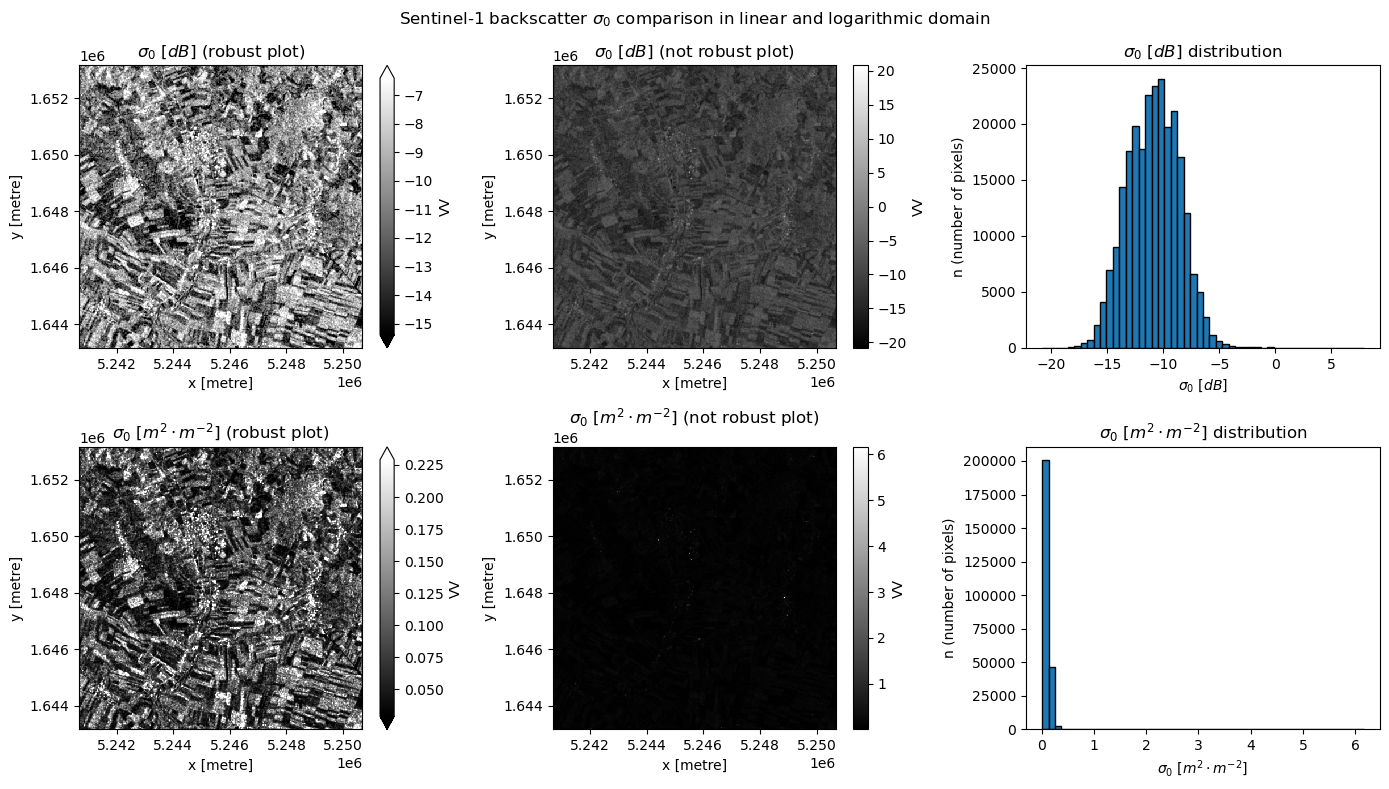

In [6]:
# Plot the data
aoi = subset.isel(time=0, x=slice(0, 500), y=slice(0, 500))
aoi_lin = 10 ** (aoi / 10)

fig, ax = plt.subplots(2, 3, figsize=(14, 8))
# upper left
ax_ul = ax[0, 0]
aoi.plot.imshow(robust=True, ax=ax_ul, cmap='grey')
ax_ul.set_title(r'$\sigma_0$ [$dB$] (robust plot)')

# upper middle
ax_um = ax[0, 1]
aoi.plot.imshow(robust=False, ax=ax_um, cmap='grey')
ax_um.set_title(r'$\sigma_0$ [$dB$] (not robust plot)')

# upper right
ax_ur = ax[0, 2]
aoi.plot.hist(bins=50, ax=ax_ur, edgecolor='black')
ax_ur.set_xlabel(r'$\sigma_0$ [$dB$]')
ax_ur.set_title(r'$\sigma_0$ [$dB$] distribution')
ax_ur.set_ylabel('n (number of pixels)')

# lower left
ax_ll = ax[1, 0]
aoi_lin.plot.imshow(robust=True, ax=ax_ll, cmap='grey')
ax_ll.set_title(r'$\sigma_0$ [$m^2 \cdot m^{-2}$] (robust plot)')

# lower middle
ax_lm = ax[1, 1]
aoi_lin.plot.imshow(robust=False, ax=ax_lm, cmap='grey')
ax_lm.set_title(r'$\sigma_0$ [$m^2 \cdot m^{-2}$] (not robust plot)')

# lower right
ax_lr = ax[1, 2]
aoi_lin.plot.hist(bins=50, ax=ax_lr, edgecolor='black')
ax_lr.set_xlabel(r'$\sigma_0$ [$m^2 \cdot m^{-2}$]')
ax_lr.set_ylabel('n (number of pixels)')
ax_lr.set_title(r'$\sigma_0$ [$m^2 \cdot m^{-2}$] distribution')
# ax_lr.set_yscale('log')

title = (r'Sentinel-1 backscatter $\sigma_0$ comparison'
         + r' in linear and logarithmic domain')
fig.suptitle(title, horizontalalignment='center')
plt.tight_layout()

In the plot above you can see the difference between the two scales. The values in dB are more evenly distributed and are therefore easier to plot. The values in linear scale are more spread out and are therefore harder to interpret.
This is why we use the dB scale for plotting/visualization.

While the logarithmic scale facilitates visual interpretation, it has implications for mathematical operations. In the following, we'll have a closer look at this. But first, let's see how we can convert between the linear and the logarithmic domains.

### Conversion Formulas
The decibel (dB) is a logarithmic unit used to express the ratio of two values of a physical quantity, often power or intensity. In the case of SAR data, the backscatter coefficient is often expressed in dB to facilitate visualization.

In order to convert the data from dB to linear scale, we use the following formula.
Let $D$ be the original value (dB) and $I$ the converted value ($m^2m^{-2}$). The conversion of units can be expressed as:
$$
D =  10  \cdot \log_{10} (I) = 10 \cdot \log_{10} (e) \cdot \ln (I)\longrightarrow [dB]
$$
Similarly, the conversion back to the original unit can be expressed as:
$$
I = e^{\frac{D}{10\cdot \log_{10}(e)}} = 10^{\frac{D}{10}} \longrightarrow [m^2m^{-2}]	
$$
You can find these formulas in the script for `Microwave Remote Sensing` on ``page 136 (equation 6.40)``.

Now let's implement the conversion in Python.

In [7]:
# Conversion functions
def lin2db(val: float | int) -> float:
    '''
    Converts value from linear to dB units.

    :param val: Value in linear units.
    :type val: float|int
    :return: Value in dB.
    :rtype: float
    '''
    return 10 * np.log10(val)


def db2lin(val: float | int) -> float:
    '''
    Converts value from dB to linear units.

    :param val: Value in dB.
    :type val: float|int
    :return: Value in linear units.
    :rtype: float
    '''
    return 10 ** (val / 10)

When performing mathematical operations with SAR data it is important to be aware, that adding values in the logarithmic scale doesn't work in the same way as adding regular (linear) values. This is because in the logarithmic scale, each unit step represents an equal multiplication. This means that an addition of two values in the logarithmic scale equals a multiplication of the values in the linear scale. Vice versa, a subtraction in a logarithmic scale equals a division in a linear scale. Let's have a look at an example, where we add two values, once without the conversion to linear scale and once with the conversion to linear scale.

In [8]:
# Logarithmic addition
# Values in linear and decibel units
val1_db, val2_db = 10, 12

# Logarithmic addition
sum_db = val1_db + val2_db
print('Logarithmic Addition:')
print(f'Logarithmic values: \t{val1_db:<5}, {val2_db:<5} [dB]')
print(f'Logarithmic sum: \t{val1_db} + {val2_db} = {sum_db:<5} [dB]')

# Linear addition
val1_lin, val2_lin = db2lin(val1_db), db2lin(val2_db)
sum_lin = val1_lin + val2_lin
print('\nLinear Addition:')
print(f'''Linear values: \t\t{val1_lin:<5}, {val2_lin:<5.2f} [lin]
      \t\t\t(converted from dB)''')
print(f'Linear sum: \t\t{val1_lin} + {val2_lin:.2f} = {sum_lin:.2f} [lin]')
print(f'\t\t\t= {lin2db(sum_lin):.2f} [dB]')

Logarithmic Addition:
Logarithmic values: 	10   , 12    [dB]
Logarithmic sum: 	10 + 12 = 22    [dB]

Linear Addition:
Linear values: 		10.0 , 15.85 [lin]
      			(converted from dB)
Linear sum: 		10.0 + 15.85 = 25.85 [lin]
			= 14.12 [dB]


As you can see, the values in dB and in linear scale differ quite a bit. In the example above, the values differ by a factor of around 6 when looked at in linear scale.

Now that we have some data, we will have a look at some practical examples where we will convert the data to linear scale.
When we try to calculate the average $\sigma_0$ value across the scene, we need to do this by converting the data to linear scale first and then calculating the average and converting it back to dB. 

### Creating a monthly mosaic 

So in the beginning we have lazily loaded data for an area across a whole year. We therefore have around 700 images. We will now essentially compress the data of each month into one timestamp. This is done by using the ``resampling`` method together with an operation method like ``mean`` or ``median``. Since the data is in dB we need to convert it to linear scale first, then we can resample the data and convert it back to dB.

In [9]:
# Convert to linear scale and calculate monthly means
# Conversion by calculating with the xarray Object
sig0_lin = 10 ** (sig0 / 10)

# Resample to monthly means. Time accepts intervals identical to the pandas resample function. 'D' for days, 'W' for weeks, 'ME' for months. 
sig0_lin_monthly = sig0_lin.resample(time='1ME').mean()

# Convert back to dB scale
# Conversion by applying a function
sig0_monthly = lin2db(sig0_lin_monthly)
sig0_monthly

<xarray.DataArray 'VV' (time: 12, y: 3150, x: 3978)> Size: 601MB
dask.array<mul, shape=(12, 3150, 3978), dtype=float32, chunksize=(1, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 25kB 1.653e+06 1.653e+06 ... 1.59e+06 1.59e+06
  * x            (x) float64 32kB 5.241e+06 5.241e+06 ... 5.32e+06 5.32e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 96B 2022-01-31 2022-02-28 ... 2022-12-31

The dataset has now only 12 timestamps, one for each month. Next, we want to calculate the average $\sigma_0$ value across the scene for one month. We will do this again by converting the data to linear scale first and then calculating the average and converting it back to dB.

In [10]:
# Lets take a data array with db values
db_array = sig0_monthly.sel(time='2022-07-30', method='nearest')

# Compute the linear values
lin_array = db2lin(db_array)

In [11]:
# Compute the average backscatter value in linear units across the whole scene
lin_mean = lin_array.mean()
print(f"Average backscatter value in linear units: {lin_mean.values:.3f}")
db_from_lin_mean = lin2db(lin_mean)
print(f"That value in dB: {db_from_lin_mean.values:.3f}\n")

# Compute the average backscatter value in dB across the whole scene
db_mean = db_array.mean()
print(f"Average backscatter value in dB: {db_mean.values:.3f}")

Average backscatter value in linear units: 0.124
That value in dB: -9.060

Average backscatter value in dB: -10.550


As you can see in the example, the mean values across the scene are different in dB and linear scale. Therefore, it is important to be aware in which scale the data is stored to perform the correct type of mathematical operation or always convert the data to linear scale before doing any calculations.

### Save Mean Mosaic as tif file

Often we want to store the output of a computation permanently on a file system. The most common file format for this is a GeoTIFF (TIF file with additional information on the georeference). The following cell indicates how this can be easily done with Xarray. When we want to store the data as a GeoTIFF we need to make sure to provide a spatial reference to geolocate the data. In Xarray this is stored in the attribute ``spatial_ref``.

In [12]:
# Select some data which we want to save
data_2_save = sig0_monthly.sel(time='2022-07-30', method='nearest')
data_2_save.spatial_ref

<xarray.DataArray 'spatial_ref' ()> Size: 4B
array(27704, dtype=int32)
Coordinates:
    spatial_ref  int32 4B 27704
    time         datetime64[ns] 8B 2022-07-31
Attributes: (12/17)
    spatial_ref:                     PROJCRS["WGS 84 / Equi7 Europe",BASEGEOG...
    crs_wkt:                         PROJCRS["WGS 84 / Equi7 Europe",BASEGEOG...
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.314245179
    inverse_flattening:              298.257223563
    reference_ellipsoid_name:        WGS 84
    ...                              ...
    grid_mapping_name:               azimuthal_equidistant
    latitude_of_projection_origin:   53.0
    longitude_of_projection_origin:  24.0
    false_easting:                   5837287.82
    false_northing:                  2121415.696
    GeoTransform:                    5240680 20 0 1653160 0 -20

In this case, the spatial reference is the EPSG Code `EPSG:27704`, which is the `Equi7Grid Europe`.
As the output dataarray already has a spatial reference we now save it as a raster file

In [13]:
# Save the data
data_2_save.rio.to_raster('sig0_mean_mosaic_july.tif',
                          tiled=True, driver="GTiff",
                          compress="LZW")

In [14]:
# Load the data again (for demonstration purposes)
loaded_data = xr.open_dataset('sig0_mean_mosaic_july.tif', engine='rasterio')
loaded_data

<xarray.Dataset> Size: 50MB
Dimensions:      (band: 1, x: 3978, y: 3150)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 32kB 5.241e+06 5.241e+06 ... 5.32e+06 5.32e+06
  * y            (y) float64 25kB 1.653e+06 1.653e+06 ... 1.59e+06 1.59e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 50MB ...

When loading the data back in, we can access this information like shown in the next cell.

In [15]:
loaded_data.rio.crs

CRS.from_epsg(27704)